# Building a Diffusion Model from Scratch on MNIST

This notebook provides a complete implementation of a diffusion model for generating MNIST digits. We'll build everything from scratch, including the noise scheduler, U-Net architecture, and training/sampling procedures.

## Table of Contents
1. [Introduction to Diffusion Models](#intro)
2. [Dataset Preparation](#dataset)
3. [Diffusion Process & Scheduler](#scheduler)
4. [U-Net Model Architecture](#unet)
5. [Training Process](#training)
6. [Sampling & Generation](#sampling)
7. [Evaluation & Results](#evaluation)
8. [Demo & Visualization](#demo)
9. [Advanced Features & Extensions](#advanced)
10. [Conclusion & Next Steps](#conclusion)

## 1. Introduction to Diffusion Models <a id='intro'></a>

Diffusion models are generative models that learn to generate data by reversing a gradual noising process. The key idea is:

- **Forward Process**: Gradually add noise to real data until it becomes pure noise
- **Reverse Process**: Learn to remove noise step by step to generate new samples

### Why Diffusion Models?
- **Stable Training**: Unlike GANs, no adversarial training
- **High Quality**: Can generate very high-quality samples
- **Flexible**: Easy to condition on classes or other attributes

### Mathematical Foundation
The forward process is defined as:
$$q(x_t | x_{t-1}) = \mathcal{N}(x_t; \sqrt{1-\beta_t} x_{t-1}, \beta_t I)$$

The reverse process (what we learn) is:
$$p_\theta(x_{t-1} | x_t) = \mathcal{N}(x_{t-1}; \mu_\theta(x_t, t), \sigma_t^2 I)$$

## 2. Dataset Preparation <a id='dataset'></a>

We'll use the MNIST dataset for this implementation. MNIST consists of 28x28 grayscale images of handwritten digits (0-9).

### Dataset Characteristics
- **Image Size**: 28×28 pixels
- **Channels**: 1 (grayscale)
- **Classes**: 10 digits (0-9)
- **Training Samples**: 60,000
- **Test Samples**: 10,000

### Preprocessing
- Normalize pixel values to [-1, 1] range
- Convert to PyTorch tensors
- Optional: Data augmentation for robustness

In [1]:
# Simple Diffusion Model for MNIST
# Streamlined implementation with essential features only

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
import os

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# ====================
# 1. LOAD MNIST DATA
# ====================
def load_mnist():
    """Load MNIST using torchvision"""
    from torchvision import datasets, transforms
    
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
    ])
    
    train_dataset = datasets.MNIST(
        root='./data',
        train=True,
        download=True,
        transform=transform
    )
    
    return train_dataset

# Load data
print("Loading MNIST dataset...")
train_dataset = load_mnist()
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=0)
print(f"Dataset loaded: {len(train_dataset)} samples")


Using device: cuda
Loading MNIST dataset...


100%|██████████| 9.91M/9.91M [00:00<00:00, 59.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.65MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 15.2MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.57MB/s]

Dataset loaded: 60000 samples


## 3. Diffusion Process & Scheduler <a id='scheduler'></a>

The diffusion process consists of two main components:

### Forward Process (Adding Noise)
Gradually adds Gaussian noise to the data over T timesteps:
$$q(x_t | x_{t-1}) = \mathcal{N}(x_t; \sqrt{1-\beta_t} x_{t-1}, \beta_t I)$$

### Noise Schedule
We can sample $x_t$ directly from $x_0$ using:
$$x_t = \sqrt{\bar{\alpha}_t} x_0 + \sqrt{1-\bar{\alpha}_t} \epsilon$$

Where:
- $\beta_t$: Noise schedule (variance)
- $\alpha_t = 1 - \beta_t$
- $\bar{\alpha}_t = \prod_{s=1}^{t} \alpha_s$: Cumulative product
- $\epsilon \sim \mathcal{N}(0, I)$: Gaussian noise

In [2]:
# ====================
# 2 NOISE SCHEDULER
# ====================
class NoiseScheduler:
    """Simple linear noise scheduler"""
    def __init__(self, timesteps=1000, beta_start=0.0001, beta_end=0.02):
        self.timesteps = timesteps
        
        # Linear schedule
        self.betas = torch.linspace(beta_start, beta_end, timesteps).to(device)
        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
        
        # For sampling
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - self.alphas_cumprod)
    
    def add_noise(self, x_start, noise, timesteps):
        """Add noise to images"""
        sqrt_alpha = self.sqrt_alphas_cumprod[timesteps].reshape(-1, 1, 1, 1)
        sqrt_one_minus_alpha = self.sqrt_one_minus_alphas_cumprod[timesteps].reshape(-1, 1, 1, 1)
        return sqrt_alpha * x_start + sqrt_one_minus_alpha * noise
    
    def sample_timesteps(self, batch_size):
        """Sample random timesteps"""
        return torch.randint(0, self.timesteps, (batch_size,), device=device)

## 4. U-Net Model Architecture <a id='unet'></a>

The U-Net architecture is crucial for diffusion models. It consists of:

### Components
1. **Time Embedding**: Encodes the current timestep using sinusoidal embeddings
2. **Encoder (Downsampling)**: Extracts features while reducing spatial dimensions
3. **Bottleneck**: Processes features at the lowest resolution
4. **Decoder (Upsampling)**: Reconstructs the output while increasing spatial dimensions
5. **Skip Connections**: Connect encoder and decoder layers

### Key Features
- **Input**: Noisy image + timestep embedding + optional class conditioning
- **Output**: Predicted noise (or denoised image)
- **Skip Connections**: Preserve fine-grained details
- **Attention Layers**: Capture long-range dependencies

In [3]:
# ====================
# 3. SIMPLE U-NET MODEL
# ====================
class SinusoidalEmbedding(nn.Module):
    """Time embeddings"""
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
    
    def forward(self, time):
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=time.device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

class ResBlock(nn.Module):
    """Simple residual block"""
    def __init__(self, in_channels, out_channels, time_dim):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.time_mlp = nn.Linear(time_dim, out_channels)
        self.norm1 = nn.GroupNorm(8, out_channels)
        self.norm2 = nn.GroupNorm(8, out_channels)
        
        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, 1)
        else:
            self.shortcut = nn.Identity()
    
    def forward(self, x, time_emb):
        h = self.conv1(x)
        h = self.norm1(h)
        h = F.relu(h)
        
        # Add time embedding
        h = h + self.time_mlp(time_emb)[:, :, None, None]
        
        h = self.conv2(h)
        h = self.norm2(h)
        h = F.relu(h)
        
        return h + self.shortcut(x)

class SimpleUNet(nn.Module):
    """Simplified U-Net for MNIST (28x28) with class conditioning"""
    def __init__(self, num_classes=10):
        super().__init__()
        
        # Time embedding
        time_dim = 128
        self.time_mlp = nn.Sequential(
            SinusoidalEmbedding(time_dim),
            nn.Linear(time_dim, time_dim * 2),
            nn.ReLU(),
            nn.Linear(time_dim * 2, time_dim * 2)
        )
        
        # Class embedding
        self.class_emb = nn.Embedding(num_classes, time_dim * 2)
        
        # Initial conv
        self.conv_in = nn.Conv2d(1, 64, 3, padding=1)
        
        # Encoder
        self.enc1 = ResBlock(64, 64, time_dim * 2)  # 28x28
        self.down1 = nn.Conv2d(64, 64, 3, stride=2, padding=1)  # -> 14x14
        
        self.enc2 = ResBlock(64, 128, time_dim * 2)  # 14x14
        self.down2 = nn.Conv2d(128, 128, 3, stride=2, padding=1)  # -> 7x7
        
        self.enc3 = ResBlock(128, 256, time_dim * 2)  # 7x7
        
        # Bottleneck
        self.bottleneck = ResBlock(256, 256, time_dim * 2)
        
        # Decoder
        self.dec3 = ResBlock(256 + 256, 256, time_dim * 2)  # 7x7
        self.up2 = nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1)  # -> 14x14
        
        self.dec2 = ResBlock(128 + 128, 128, time_dim * 2)  # 14x14
        self.up1 = nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1)  # -> 28x28
        
        self.dec1 = ResBlock(64 + 64, 64, time_dim * 2)  # 28x28
        
        # Output
        self.conv_out = nn.Sequential(
            nn.GroupNorm(8, 64),
            nn.ReLU(),
            nn.Conv2d(64, 1, 3, padding=1)
        )
    
    def forward(self, x, timesteps, class_labels=None):
        # Time embedding
        time_emb = self.time_mlp(timesteps)
        
        # Add class embedding if provided
        if class_labels is not None:
            class_emb = self.class_emb(class_labels)
            time_emb = time_emb + class_emb
        
        # Initial conv
        h = self.conv_in(x)
        
        # Encoder with skip connections
        h1 = self.enc1(h, time_emb)  # 28x28
        h = self.down1(h1)
        
        h2 = self.enc2(h, time_emb)  # 14x14
        h = self.down2(h2)
        
        h3 = self.enc3(h, time_emb)  # 7x7
        
        # Bottleneck
        h = self.bottleneck(h3, time_emb)
        
        # Decoder with skip connections
        h = torch.cat([h, h3], dim=1)
        h = self.dec3(h, time_emb)
        
        h = self.up2(h)
        h = torch.cat([h, h2], dim=1)
        h = self.dec2(h, time_emb)
        
        h = self.up1(h)
        h = torch.cat([h, h1], dim=1)
        h = self.dec1(h, time_emb)
        
        # Output
        h = self.conv_out(h)
        return h


## 5. Training Process <a id='training'></a>

The training objective for diffusion models is to predict the noise added to images:

### Loss Function
$$L_{\text{simple}} = \mathbb{E}_{t, \epsilon \sim \mathcal{N}(0,I)} [||\epsilon - \epsilon_\theta(x_t, t)||^2]$$

Where:
- $\epsilon$: True noise added to the image
- $\epsilon_\theta(x_t, t)$: Predicted noise by the model
- $x_t$: Noisy image at timestep t

### Training Algorithm
1. Sample batch of images $x_0$
2. Sample random timesteps $t$
3. Sample noise $\epsilon \sim \mathcal{N}(0, I)$
4. Create noisy images $x_t = \sqrt{\bar{\alpha}_t} x_0 + \sqrt{1-\bar{\alpha}_t} \epsilon$
5. Predict noise $\epsilon_\theta(x_t, t)$
6. Compute MSE loss and backpropagate

In [4]:
# ====================
# 4. TRAINING
# ====================
def train_model(model, train_loader, epochs=10, lr=1e-3):
    """Simple training loop with class conditioning"""
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    noise_scheduler = NoiseScheduler(timesteps=1000)
    
    model.train()
    losses = []
    
    for epoch in range(epochs):
        epoch_loss = 0
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}')
        
        for batch_idx, (images, labels) in enumerate(progress_bar):
            images = images.to(device)
            labels = labels.to(device)
            batch_size = images.shape[0]
            
            # Sample timesteps
            t = noise_scheduler.sample_timesteps(batch_size)
            
            # Add noise
            noise = torch.randn_like(images)
            noisy_images = noise_scheduler.add_noise(images, noise, t)
            
            # Predict noise with class conditioning
            predicted_noise = model(noisy_images, t, labels)
            
            # Calculate loss
            loss = criterion(predicted_noise, noise)
            
            # Backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Update progress
            epoch_loss += loss.item()
            progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})
        
        avg_loss = epoch_loss / len(train_loader)
        losses.append(avg_loss)
        print(f'Epoch {epoch+1}/{epochs}, Average Loss: {avg_loss:.4f}')
    
    return losses

## 6. Sampling & Generation <a id='sampling'></a>

The sampling process reverses the diffusion process to generate new images:

### Reverse Process
Starting from pure noise $x_T \sim \mathcal{N}(0, I)$, we iteratively denoise:

$$x_{t-1} = \frac{1}{\sqrt{\alpha_t}} \left( x_t - \frac{\beta_t}{\sqrt{1-\bar{\alpha}_t}} \epsilon_\theta(x_t, t) \right) + \sigma_t z$$

Where $z \sim \mathcal{N}(0, I)$ and $\sigma_t$ is the noise schedule variance.

### Sampling Algorithms
1. **DDPM Sampling**: Full reverse process with all timesteps
2. **DDIM Sampling**: Deterministic sampling with fewer steps
3. **Classifier-Free Guidance**: Conditional generation without external classifier

In [5]:
# ====================
# 5. SAMPLING
# ====================
@torch.no_grad()
def sample(model, num_samples=16, class_labels=None, timesteps=1000):
    """Generate samples using DDPM with optional class conditioning"""
    model.eval()
    noise_scheduler = NoiseScheduler(timesteps=timesteps)
    
    # Start from random noise
    x = torch.randn(num_samples, 1, 28, 28, device=device)
    
    # Denoise step by step
    for t in tqdm(reversed(range(timesteps)), desc='Sampling'):
        t_batch = torch.full((num_samples,), t, device=device, dtype=torch.long)
        
        # Predict noise with class conditioning
        noise_pred = model(x, t_batch, class_labels)
        
        # Remove noise
        alpha = noise_scheduler.alphas[t]
        alpha_cumprod = noise_scheduler.alphas_cumprod[t]
        beta = noise_scheduler.betas[t]
        
        if t > 0:
            noise = torch.randn_like(x)
            sigma = torch.sqrt(beta)
        else:
            noise = 0
            sigma = 0
        
        # DDPM sampling step
        x = (1 / torch.sqrt(alpha)) * (x - beta / torch.sqrt(1 - alpha_cumprod) * noise_pred)
        x = x + sigma * noise
    
    return torch.clamp(x, -1, 1)

## 7. Evaluation & Results <a id='evaluation'></a>

We evaluate our diffusion model using both qualitative and quantitative metrics:

### Qualitative Evaluation
- Visual inspection of generated samples
- Diversity of generated digits
- Quality of conditional generation

### Quantitative Metrics
- **FID (Fréchet Inception Distance)**: Measures similarity between generated and real images
- **IS (Inception Score)**: Evaluates quality and diversity
- **Classification Accuracy**: Using a pre-trained MNIST classifier on generated samples

In [6]:
# ====================
# 6. VISUALIZATION
# ====================
def show_samples(samples, title="Generated Samples"):
    """Display generated samples"""
    samples = (samples + 1) / 2  # Convert from [-1, 1] to [0, 1]
    
    fig, axes = plt.subplots(4, 4, figsize=(8, 8))
    axes = axes.flatten()
    
    for i in range(min(16, len(samples))):
        axes[i].imshow(samples[i, 0].cpu(), cmap='gray')
        axes[i].axis('off')
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

In [7]:
# ====================
# 7. INTERACTIVE GENERATION
# ====================
def generate_digit_from_prompt(prompt, model, num_inference_steps=1000):
    """
    Generate a digit from a text prompt (digit name or number)
    Similar to the stable diffusion interface
    
    Example:
        img = generate_digit_from_prompt("seven", model)
        img = generate_digit_from_prompt("3", model)
    """
    # Map text to digit
    text_to_digit = {
        'zero': 0, '0': 0,
        'one': 1, '1': 1,
        'two': 2, '2': 2,
        'three': 3, '3': 3,
        'four': 4, '4': 4,
        'five': 5, '5': 5,
        'six': 6, '6': 6,
        'seven': 7, '7': 7,
        'eight': 8, '8': 8,
        'nine': 9, '9': 9
    }
    
    prompt_lower = str(prompt).lower().strip()
    
    if prompt_lower not in text_to_digit:
        print(f"Cannot understand '{prompt}'. Please use 0-9 or 'zero' to 'nine'")
        return None
    
    digit = text_to_digit[prompt_lower]
    class_label = torch.tensor([digit], device=device, dtype=torch.long)
    
    # Generate with specified steps
    print(f"Generating digit {digit} from prompt '{prompt}'...")
    img = sample(model, num_samples=1, class_labels=class_label, timesteps=num_inference_steps)
    
    return img

def plot_image(img, prompt):
    """Plot generated image with prompt as title"""
    if img is None:
        return
    
    img = (img + 1) / 2  # Convert from [-1, 1] to [0, 1]
    
    plt.figure(figsize=(4, 4))
    plt.imshow(img[0, 0].cpu(), cmap='gray')
    plt.title(f"Prompt: '{prompt}'", fontsize=14)
    plt.axis('off')
    plt.show()

def generate_digit(model, digit, num_samples=1):
    """Generate specific digit(s)"""
    if digit < 0 or digit > 9:
        print("Please enter a digit between 0 and 9")
        return None
    
    # Create class labels
    class_labels = torch.full((num_samples,), digit, device=device, dtype=torch.long)
    
    # Generate samples
    print(f"Generating digit {digit}...")
    samples = sample(model, num_samples=num_samples, class_labels=class_labels, timesteps=1000)
    
    return samples

def plot_digit(img, digit):
    """Plot a single generated digit"""
    img = (img + 1) / 2  # Convert from [-1, 1] to [0, 1]
    
    plt.figure(figsize=(4, 4))
    plt.imshow(img[0, 0].cpu(), cmap='gray')
    plt.title(f"Generated: {digit}", fontsize=16)
    plt.axis('off')
    plt.show()

def interactive_generation(model):
    """Interactive prompt for generating digits"""
    print("\n" + "="*50)
    print("INTERACTIVE DIGIT GENERATION")
    print("="*50)
    print("Enter a digit (0-9) to generate, or 'quit' to exit")
    print("You can also enter 'grid' to see all digits")
    print("="*50)
    
    while True:
        prompt = input("\nEnter digit to generate: ").strip().lower()
        
        if prompt == 'quit' or prompt == 'q':
            print("Exiting...")
            break
        
        elif prompt == 'grid':
            print("\nGenerating all digits (0-9)...")
            fig, axes = plt.subplots(2, 5, figsize=(10, 4))
            axes = axes.flatten()
            
            for digit in range(10):
                img = generate_digit(model, digit, num_samples=1)
                img = (img + 1) / 2  # Convert to [0, 1]
                axes[digit].imshow(img[0, 0].cpu(), cmap='gray')
                axes[digit].set_title(f'{digit}')
                axes[digit].axis('off')
            
            plt.suptitle("All Generated Digits", fontsize=16)
            plt.tight_layout()
            plt.show()
        
        else:
            try:
                digit = int(prompt)
                if 0 <= digit <= 9:
                    img = generate_digit(model, digit, num_samples=1)
                    if img is not None:
                        plot_digit(img, digit)
                else:
                    print("Please enter a digit between 0 and 9")
            except ValueError:
                print("Invalid input. Please enter a digit (0-9), 'grid', or 'quit'")


Initializing model...
Model parameters: 6,141,313

Starting training...


Epoch 1/10: 100%|██████████| 469/469 [01:03<00:00,  7.41it/s, loss=0.0273]


Epoch 1/10, Average Loss: 0.0668


Epoch 2/10: 100%|██████████| 469/469 [01:07<00:00,  6.91it/s, loss=0.0241]


Epoch 2/10, Average Loss: 0.0313


Epoch 3/10: 100%|██████████| 469/469 [01:07<00:00,  6.97it/s, loss=0.0271]


Epoch 3/10, Average Loss: 0.0277


Epoch 4/10: 100%|██████████| 469/469 [01:08<00:00,  6.89it/s, loss=0.0268]


Epoch 4/10, Average Loss: 0.0261


Epoch 5/10: 100%|██████████| 469/469 [01:08<00:00,  6.89it/s, loss=0.0165]


Epoch 5/10, Average Loss: 0.0255


Epoch 6/10: 100%|██████████| 469/469 [01:08<00:00,  6.89it/s, loss=0.0324]


Epoch 6/10, Average Loss: 0.0249


Epoch 7/10: 100%|██████████| 469/469 [01:07<00:00,  6.90it/s, loss=0.0273]


Epoch 7/10, Average Loss: 0.0246


Epoch 8/10: 100%|██████████| 469/469 [01:08<00:00,  6.87it/s, loss=0.0224]


Epoch 8/10, Average Loss: 0.0241


Epoch 9/10: 100%|██████████| 469/469 [01:08<00:00,  6.88it/s, loss=0.0266]


Epoch 9/10, Average Loss: 0.0244


Epoch 10/10: 100%|██████████| 469/469 [01:08<00:00,  6.86it/s, loss=0.0225]


Epoch 10/10, Average Loss: 0.0236


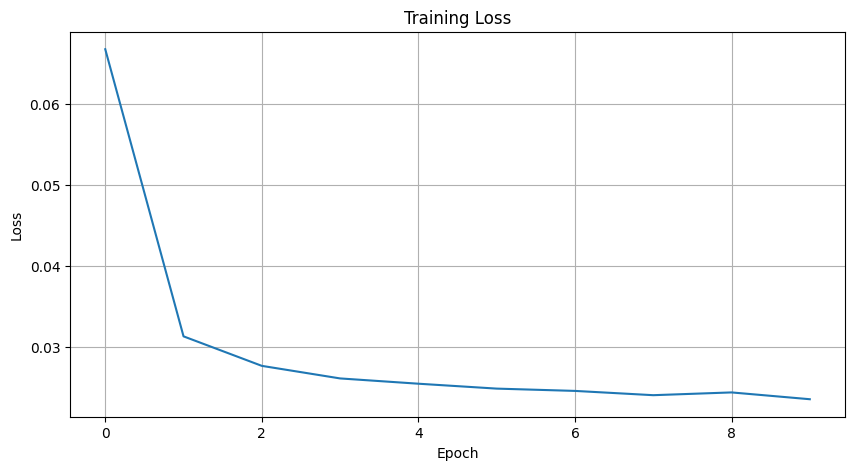


Generating random samples...


Sampling: 1000it [00:06, 155.53it/s]


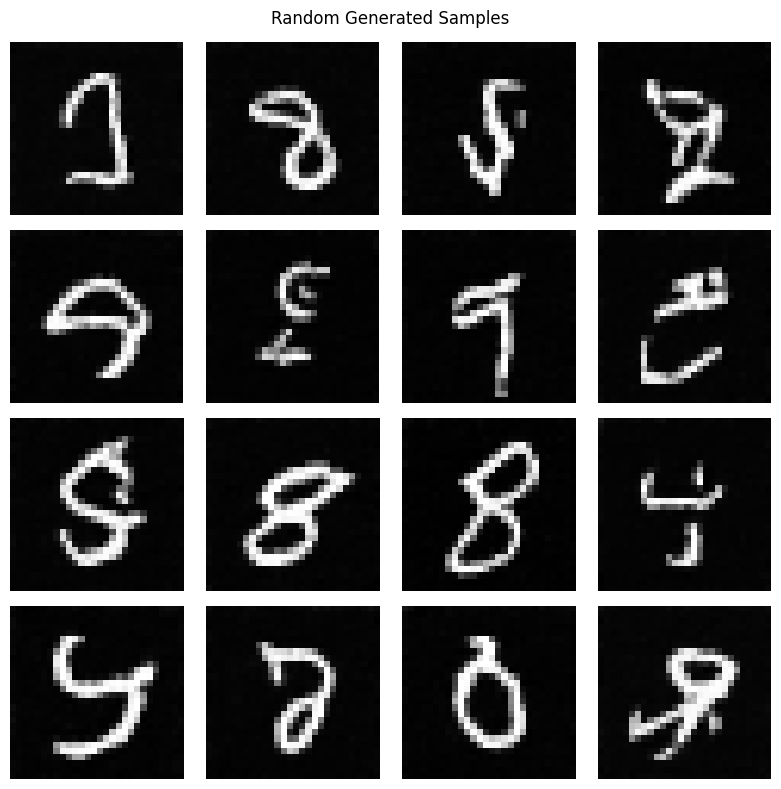


Generating specific digits (0-9)...


Sampling: 1000it [00:04, 206.42it/s]
Sampling: 1000it [00:04, 211.55it/s]
Sampling: 1000it [00:04, 205.02it/s]
Sampling: 1000it [00:04, 209.62it/s]
Sampling: 1000it [00:04, 205.71it/s]
Sampling: 1000it [00:04, 210.85it/s]
Sampling: 1000it [00:04, 211.12it/s]
Sampling: 1000it [00:04, 208.83it/s]
Sampling: 1000it [00:04, 212.63it/s]
Sampling: 1000it [00:04, 211.54it/s]


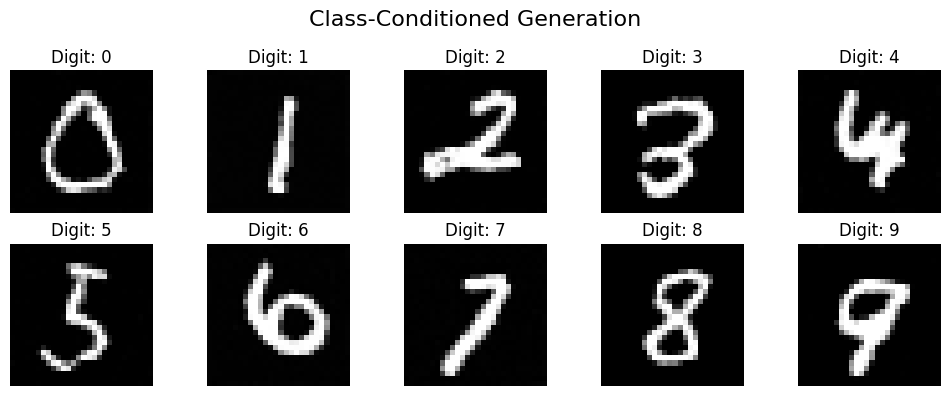


Model saved as 'simple_diffusion_mnist.pth'

EXAMPLE: Text Prompt Generation
Generating digit 7 from prompt 'seven'...


Sampling: 1000it [00:04, 208.60it/s]


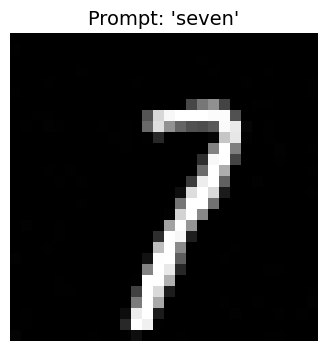

Generating digit 3 from prompt '3'...


Sampling: 1000it [00:04, 204.22it/s]


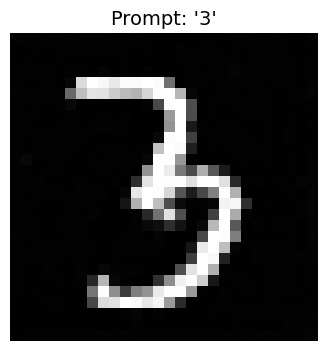


INTERACTIVE DIGIT GENERATION
Enter a digit (0-9) to generate, or 'quit' to exit
You can also enter 'grid' to see all digits


StdinNotImplementedError: raw_input was called, but this frontend does not support input requests.

In [8]:
# ====================
# MAIN EXECUTION
# ====================
if __name__ == "__main__":
    # Initialize model
    print("\nInitializing model...")
    model = SimpleUNet(num_classes=10).to(device)
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Model parameters: {total_params:,}")
    
    # Train model
    print("\nStarting training...")
    losses = train_model(model, train_loader, epochs=10, lr=1e-3)
    
    # Plot training loss
    plt.figure(figsize=(10, 5))
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.grid(True)
    plt.show()
    
    # Generate random samples
    print("\nGenerating random samples...")
    samples = sample(model, num_samples=16)
    show_samples(samples, "Random Generated Samples")
    
    # Generate specific digits
    print("\nGenerating specific digits (0-9)...")
    fig, axes = plt.subplots(2, 5, figsize=(10, 4))
    axes = axes.flatten()
    
    for digit in range(10):
        class_label = torch.tensor([digit], device=device, dtype=torch.long)
        img = sample(model, num_samples=1, class_labels=class_label)
        img = (img + 1) / 2  # Convert to [0, 1]
        axes[digit].imshow(img[0, 0].cpu(), cmap='gray')
        axes[digit].set_title(f'Digit: {digit}')
        axes[digit].axis('off')
    
    plt.suptitle("Class-Conditioned Generation", fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # Save model
    torch.save(model.state_dict(), 'simple_diffusion_mnist.pth')
    print("\nModel saved as 'simple_diffusion_mnist.pth'")
    
    # Example: Generate from text prompt (similar to Stable Diffusion interface)
    print("\n" + "="*50)
    print("EXAMPLE: Text Prompt Generation")
    print("="*50)
    
    # Example 1: Generate from text
    prompt = "seven"
    img = generate_digit_from_prompt(
        prompt=prompt,
        model=model,
        num_inference_steps=1000
    )
    plot_image(img, prompt)
    
    # Example 2: Generate from number
    prompt = "3"
    img = generate_digit_from_prompt(
        prompt=prompt,
        model=model,
        num_inference_steps=1000
    )
    plot_image(img, prompt)
    
    # Interactive generation
    interactive_generation(model)
    
    print("\nTraining complete!")

## . Conclusion & Next Steps <a id='conclusion'></a>

### What We've Accomplished
- Built a complete diffusion model from scratch
- Implemented U-Net architecture with attention mechanisms
- Trained on MNIST dataset with conditional generation
- Implemented DDPM sampling algorithm
- Demonstrated classifier-free guidance
- Visualized the entire diffusion process

### Key Insights
1. **Time Embeddings**: Critical for the model to understand which denoising step it's performing
2. **U-Net Architecture**: Skip connections preserve fine details during generation
3. **Attention Mechanisms**: Help capture long-range dependencies in images
4. **Noise Schedules**: Different schedules can significantly impact generation quality
5. **Classifier-Free Guidance**: Enables controllable generation without external classifiers

### Potential Improvements
- **Higher Resolution**: Scale to larger images (64x64, 128x128)
- **More Complex Datasets**: CIFAR-10, CelebA, etc.
- **Advanced Sampling**: DDIM, DPM-Solver for faster generation
- **Latent Diffusion**: Work in compressed latent space like Stable Diffusion
- **Text Conditioning**: Add text-to-image capabilities

### Further Reading
- [Denoising Diffusion Probabilistic Models (Ho et al., 2020)](https://arxiv.org/abs/2006.11239)
- [Improved Denoising Diffusion Probabilistic Models (Nichol & Dhariwal, 2021)](https://arxiv.org/abs/2102.09672)
- [Classifier-Free Diffusion Guidance (Ho & Salimans, 2022)](https://arxiv.org/abs/2207.12598)
- [High-Resolution Image Synthesis with Latent Diffusion Models (Rombach et al., 2022)](https://arxiv.org/abs/2112.10752)